In [68]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement string (from versions: none)
ERROR: No matching distribution found for string


# Read the file

In [69]:
import numpy as np
import tensorflow as tf
import sklearn as sklearn
import pandas as pd 
import matplotlib.pyplot as plt
import string
import inflect
import contractions

In [70]:
with open("Sentences_75Agree_sample.txt", "r") as f:
    lines = f.readlines()
lines[:5]

['According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral\n',
 'With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .@positive\n',
 "For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .@positive\n",
 'In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .@positive\n',
 'Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .@positive\n']

In [71]:
data = [line.strip().split("@") for line in lines]
data[:5]


[['According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
  'neutral'],
 ['With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .',
  'positive'],
 ["For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
  'positive'],
 ['In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .',
  'positive'],
 ['Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .',
  'positive']]

In [72]:
data = pd.DataFrame(data, columns=["sentence", "label"])
data.head(10)

,sentence,label
0,"According to Gran , the company has no plans t...",neutral
1,With the new production plant the company woul...,positive
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,"In the third quarter of 2010 , net sales incre...",positive
4,Operating profit rose to EUR 13.1 mn from EUR ...,positive
5,"Operating profit totalled EUR 21.1 mn , up fro...",positive
6,TeliaSonera TLSN said the offer is in line wit...,positive
7,"STORA ENSO , NORSKE SKOG , M-REAL , UPM-KYMMEN...",positive
8,"A purchase agreement for 7,200 tons of gasolin...",positive
9,Finnish Talentum reports its operating profit ...,positive


1) Need to tokenize then
2) pre process the text, remove stop words and filler words
3) create tensorflow model with soft max 

# EDA

(array([621.,   0., 830.,   0.,  41.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. ]),
 <BarContainer object of 5 artists>)

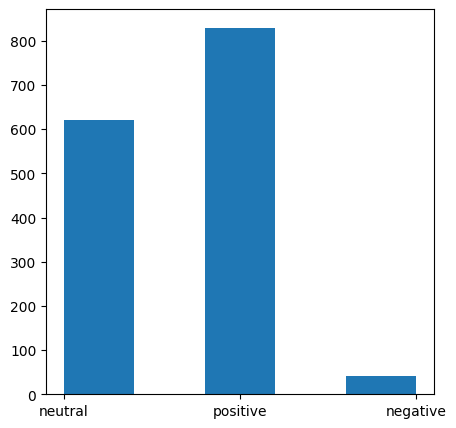

In [73]:
plt.figure(figsize=(5, 5))
plt.hist(data["label"], bins=5)


In [74]:
data.isnull().sum() # No null values

sentence    0
label       0
dtype: int64

## Lower case the words

In [75]:
def lower_case(word):
    return word.lower()
data["sentence"] = data["sentence"].apply(lower_case)

In [76]:
# Drop duplicates, in this case 2 duplicates
before = data.shape[0]
data = data.drop_duplicates(subset=["sentence"])
after = data.shape[0]
print(f"Number of duplicates removed: {before - after}")
print(data.shape[0])

Number of duplicates removed: 2
1490


## Remove HTML tags

In [77]:
import re
def remove_html(text):
    html_tags = re.compile(r'<.*?>')
    text = html_tags.sub(r'', text)
    return text
data["sentence"] = data["sentence"].apply(remove_html)

## Remove Punctuations

In [78]:
def remove_punctuation(word):
    table = str.maketrans('', '', string.punctuation)
    return word.translate(table)
# Applies translation table to remove punctuation

data["sentence"] = data["sentence"].apply(remove_punctuation)

In [79]:
data.head()

,sentence,label
0,according to gran the company has no plans to...,neutral
1,with the new production plant the company woul...,positive
2,for the last quarter of 2010 componenta s net...,positive
3,in the third quarter of 2010 net sales increa...,positive
4,operating profit rose to eur 131 mn from eur 8...,positive


# Remove Contraction

In [80]:
# convert all float into strings 
data['sentence'] = data['sentence'].apply(lambda x: (str(int(x)) if isinstance(x, float) else x))

In [81]:
# convert all to strings 
p = inflect.engine()
def convert_number(text):
    # split the string into a list of words
    temp_str = text.split()
    new_string = []

    for word in temp_str:
        if word.isdigit():
            temp = p.number_to_words(word)
            new_string.append(temp)
        else:
            new_string.append(word)

    # join the list into a string
    temp_str = " ".join(new_string)
    return temp_str

data['sentence'] = data['sentence'].apply(convert_number)

In [82]:
data['sentence'] = data['sentence'].apply(contractions.fix)

In [83]:
data.head(-5)

,sentence,label
0,according to gran the company has no plans to ...,neutral
1,with the new production plant the company woul...,positive
2,for the last quarter of two thousand and ten c...,positive
3,in the third quarter of two thousand and ten n...,positive
4,operating profit rose to eur one hundred and t...,positive
...,...,...
1482,the company s net profit amounted to ee five h...,positive
1483,the company said that it will supply the wcdma...,positive
1484,the fair value of investment properties totall...,positive
1485,the optimization of the steel components heati...,positive


# Tokenization before performing Lemmatization and Stop Word removal

In [84]:
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

tokenizer = TweetTokenizer()
data['sentence'] = data['sentence'].apply(tokenizer.tokenize) # no need args

In [89]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eugen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eugen\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [101]:
stop_words = stopwords.words("english")
keep_words =  ["no","not", "on", "off", "too", "out", "over", "under"]
print("number of stopwords including important ones: " ,len(stop_words))
for word in keep_words:
    if word in stop_words:
        stop_words.remove(word)
print(stop_words)
print("Number of stopwords excluding important ones: ", len(stop_words))

number of stopwords including important ones:  198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'nor', 'now', 'o', 'of', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'own', 're', 's', 'same', 'shan', "sha

In [104]:
def filter_token(tokens):
    return [token for token in tokens if token not in stop_words]
data['sentence'] = data['sentence'].apply(filter_token)

## Lemmatization

In [116]:
lemm = WordNetLemmatizer()
def lemm_token(tokens):
    return " ".join([lemm.lemmatize(token) for token in tokens])
data['sentence'] = data['sentence'].apply(lemm_token)


In [117]:
data.head(-5)

,sentence,label
0,according gran company no plan move production...,neutral
1,new production plant company would increase ca...,positive
2,last quarter two thousand ten componenta net s...,positive
3,third quarter two thousand ten net sale increa...,positive
4,operating profit rose eur one hundred thirty-o...,positive
...,...,...
1482,company net profit amounted ee five hundred fi...,positive
1483,company said supply wcdma 3ghspa radio network...,positive
1484,fair value investment property totalled eur tw...,positive
1485,optimization steel component heating process r...,positive


# Word Cloud

In [86]:
import wordcloud as wc
def plot_wordcloud(text):
    wordcloud = wc.WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

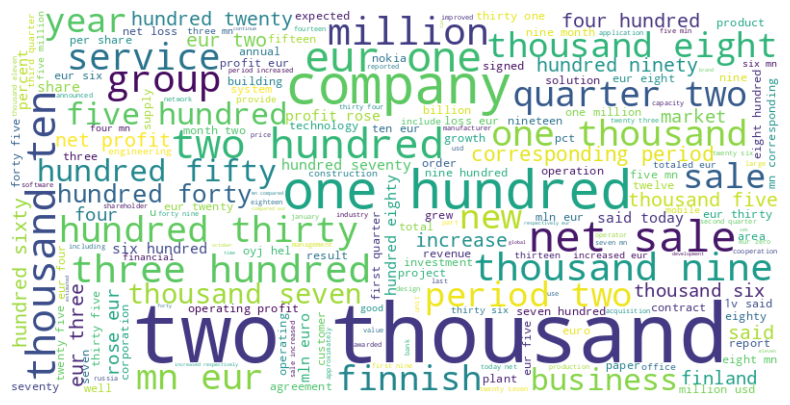

In [123]:
positive_data = data[data['label'] == "positive"] 
positive_words = ""
for sentence in data['sentence']:
    positive_words += sentence
plot_wordcloud(positive_words)

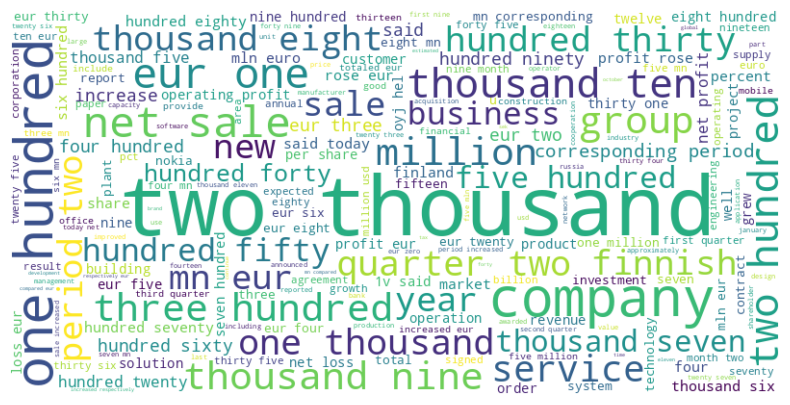

In [125]:
neutral_data = data[data['label'] == "neutral"] 
neutral_words = ""
for sentence in data['sentence']:
    neutral_words += sentence
plot_wordcloud(neutral_words)

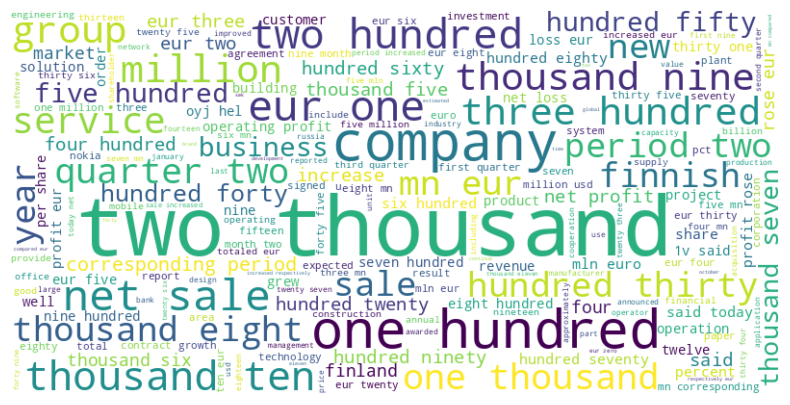

In [126]:
negative_data = data[data['label'] == "negative"] 
negative_words = ""
for sentence in data['sentence']:
    negative_words += sentence
plot_wordcloud(negative_words)

# Vectorization

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['sentence'])


In [143]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
y = label.fit_transform(data['label'])
print(y)

[1 2 2 ... 2 2 2]


In [148]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
# Need to convert to dense matrix for NN compatibility
X_train = X_train.todense()
X_test = X_test.todense()

# Model Building Tensorflow

In [169]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(units = 64, activation = "relu", input_shape=(X_train.shape[1],)),
    Dropout(0.5, seed = 42),
    Dense(units = 3, activation = "softmax")
])
model.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics = ["accuracy"])

c:\Users\eugen\Documents\Tensorflow_Sentiment_Analysis\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [170]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │       278,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 278,979 (1.06 MB)

 Trainable params: 278,979 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [171]:
history = model.fit(X_train, y_train, epochs=30, verbose=1, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.4251 - loss: 1.0792 - val_accuracy: 0.5839 - val_loss: 0.9742
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6035 - loss: 0.9321 - val_accuracy: 0.6107 - val_loss: 0.8232
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7423 - loss: 0.7658 - val_accuracy: 0.7617 - val_loss: 0.7093
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8642 - loss: 0.6153 - val_accuracy: 0.8054 - val_loss: 0.6281
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8884 - loss: 0.5098 - val_accuracy: 0.8054 - val_loss: 0.5667
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9117 - loss: 0.4145 - val_accuracy: 0.7987 - val_loss: 0.5237
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9281 - loss: 0.3459 - val_accuracy: 0.8020 - val_loss: 0.4945
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9488 - loss: 0.2672 - val_accuracy: 0.8121 - va

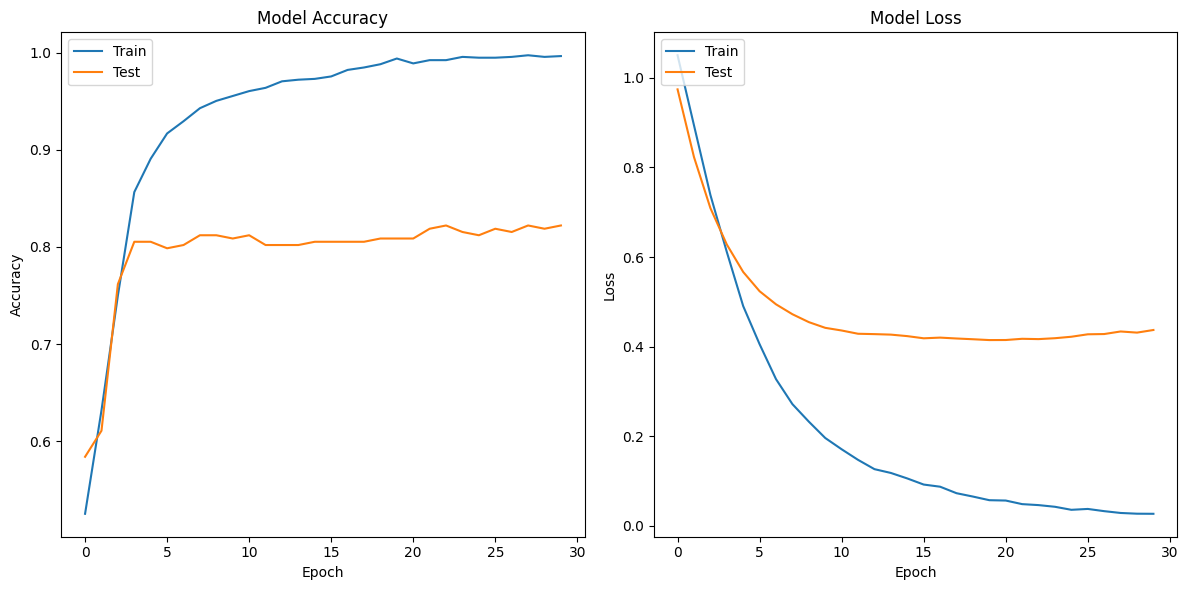

In [173]:
# plot figure
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Adjust the layout and display the plots
plt.tight_layout()


In [175]:
loss, accuracy = model.evaluate(X_test, y_test)
# Print loss and accuracy
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8325 - loss: 0.4048
Loss: 0.4372212886810303
Accuracy: 0.8221476674079895


# Keras optimizer, Hyperpram tuning

In [ ]:
# %pip install keras_tuner


   ---------------------------------------- 0/2 [kt-legacy]
   ---------------------------------------- 0/2 [kt-legacy]
   -------------------- ------------------- 1/2 [keras_tuner]
   -------------------- ------------------- 1/2 [keras_tuner]
   -------------------- ------------------- 1/2 [keras_tuner]
   -------------------- ------------------- 1/2 [keras_tuner]
   -------------------- ------------------- 1/2 [keras_tuner]
   -------------------- ------------------- 1/2 [keras_tuner]
   -------------------- ------------------- 1/2 [keras_tuner]
   -------------------- ------------------- 1/2 [keras_tuner]
   -------------------- ------------------- 1/2 [keras_tuner]
   -------------------- ------------------- 1/2 [keras_tuner]
   ---------------------------------------- 2/2 [keras_tuner]

Note: you may need to restart the kernel to use updated packages.


In [179]:
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units = hp.Int("units", min_value = 64, max_value = 512, step=64),
        activation = hp.Choice("activation", values = ['relu', 'tanh']),
        input_shape=(X_train.shape[1],)
    ))
    model.add(Dropout(
        rate = hp.Float("rate", min_value = 0.0, max_value=0.5, step=0.1)
    ))
    model.add(Dense(units =3, activation = "softmax"))
    model.compile(
        optimizer= Adam(),
        loss = "sparse_categorical_crossentropy",
        metrics = ['accuracy']
    )
    return model

In [180]:
# Confi# Configure and run the hyperparameter search:

# Initialize the random search tuner
tuner_step = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=3,
    directory='tuner_step_directory',
    project_name='step_tuning')

c:\Users\eugen\Documents\Tensorflow_Sentiment_Analysis\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [181]:
# Start the hyperparameter tuning

# Execute the search over the specified epochs and validation data
tuner_step.search(X_train,
                   y_train,
                   epochs=10,
                   validation_data=(X_test,
                                    y_test))

Trial 20 Complete [00h 00m 53s]
val_accuracy: 0.81879194577535

Best val_accuracy So Far: 0.8255033691724142
Total elapsed time: 00h 15m 50s


In [182]:
# Review the search results :

# Output the summary of the hyperparameter tuning results
tuner_step.results_summary()

Results summary
Results in tuner_step_directory\step_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 12 summary
Hyperparameters:
units: 384
activation: relu
rate: 0.30000000000000004
Score: 0.8255033691724142

Trial 13 summary
Hyperparameters:
units: 192
activation: relu
rate: 0.30000000000000004
Score: 0.8232662280400594

Trial 19 summary
Hyperparameters:
units: 64
activation: relu
rate: 0.0
Score: 0.81879194577535

Trial 04 summary
Hyperparameters:
units: 64
activation: relu
rate: 0.30000000000000004
Score: 0.818791925907135

Trial 10 summary
Hyperparameters:
units: 384
activation: relu
rate: 0.2
Score: 0.81767338514328

Trial 16 summary
Hyperparameters:
units: 384
activation: relu
rate: 0.4
Score: 0.8165548245112101

Trial 02 summary
Hyperparameters:
units: 256
activation: tanh
rate: 0.0
Score: 0.8165548046429952

Trial 15 summary
Hyperparameters:
units: 384
activation: tanh
rate: 0.1
Score: 0.8165548046429952

Trial 00 summary
Hyperparameters:
u

In [190]:
best_hp = tuner_step.get_best_hyperparameters()[0]
print(f"""
Units: {best_hp.get('units')}
Activation: {best_hp.get('activation')}
Dropout Rate: {best_hp.get('rate')}
""")



Units: 384
Activation: relu
Dropout Rate: 0.30000000000000004



# Conduct another Hyper pram tuning with Optimizer and Learning rate

In [218]:
def build_model_step2(hp):
    model = tf.keras.Sequential()
    # Add the first layer with the best hyperparameters from step 1
    model.add(Dense(
        units=tuner_step.get_best_hyperparameters()[0].get('units'),
        activation=tuner_step.get_best_hyperparameters()[0].get('activation'),
        input_shape=(X_train.shape[1],)
    ))
    # Add the dropout layer with the best hyperparameter from step 1
    model.add(Dropout(
        rate=tuner_step.get_best_hyperparameters()[0].get('rate')
    ))
    # Add a second dense layer where the number of units is a new hyperparameter to tune
    model.add(tf.keras.layers.Dense(
        units=hp.Int('second_units', min_value=32, max_value=512, step=32),
        activation='softmax'
    ))

    # Set optimizer and learning rate as new hyperparameters to tune
    optimizer_selected = hp.Choice('optimizer', values=['adam', 'sgd'])
    learning_rate_selected = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Conditional logic to instantiate the selected optimizer with the selected learning rate
    if optimizer_selected == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_selected)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_selected)

    # Compile the model with the selected optimizer, loss, and metric
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [223]:
# Initialize and run the second hyperparameter search:

# Initialize the second tuner with a new search space
tuner_step2 = kt.RandomSearch(
    build_model_step2,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=3,
    directory='tuner_step2_again_directory',
    project_name='step2_tuning'
)

# Execute the search with the same training and validation data
tuner_step2.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Trial 20 Complete [00h 00m 41s]
val_accuracy: 0.8154362440109253

Best val_accuracy So Far: 0.8243847886721293
Total elapsed time: 00h 13m 41s


In [224]:
# Output the summary of the hyperparameter tuning results from step 2
tuner_step2.results_summary()

Results summary
Results in tuner_step2_again_directory\step2_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
second_units: 224
optimizer: adam
learning_rate: 0.01
Score: 0.8243847886721293

Trial 14 summary
Hyperparameters:
second_units: 512
optimizer: adam
learning_rate: 0.01
Score: 0.8165548245112101

Trial 19 summary
Hyperparameters:
second_units: 480
optimizer: adam
learning_rate: 0.01
Score: 0.8154362440109253

Trial 10 summary
Hyperparameters:
second_units: 352
optimizer: adam
learning_rate: 0.01
Score: 0.8143176833788554

Trial 08 summary
Hyperparameters:
second_units: 416
optimizer: adam
learning_rate: 0.001
Score: 0.8131991227467855

Trial 13 summary
Hyperparameters:
second_units: 448
optimizer: adam
learning_rate: 0.001
Score: 0.8131991028785706

Trial 03 summary
Hyperparameters:
second_units: 160
optimizer: adam
learning_rate: 0.01
Score: 0.8120805422465006

Trial 12 summary
Hyperparameters:
second_units: 448
o

In [225]:
def build_final_model(best_hp, best_hps_step2):
    model = tf.keras.Sequential()

    # First dense layer with best units and activation from step 1
    model.add(tf.keras.layers.Dense(
        units=best_hp.get('units'),
        activation=best_hp.get('activation'),
        input_shape=(X_train.shape[1],)
    ))

    # Dropout layer with the best rate from step 1
    model.add(tf.keras.layers.Dropout(best_hp.get('rate')))

    # Second dense layer with best units from step 2
    model.add(tf.keras.layers.Dense(
        units=best_hps_step2.get('second_units'),
        activation='softmax'
    ))

    # Set the optimizer with the best type and learning rate from step 2
    if best_hps_step2.get('optimizer') == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=best_hps_step2.get('learning_rate'))
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=best_hps_step2.get('learning_rate'))

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [226]:
best_hps_step2 = tuner_step2.get_best_hyperparameters()[0]

final_model = build_final_model(best_hp=best_hp, best_hps_step2=best_hps_step2)

In [227]:
history_final = final_model.fit(X_train, y_train, verbose=1, batch_size=32, epochs=10, validation_data=(X_test,y_test))

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5525 - loss: 2.5173 - val_accuracy: 0.7886 - val_loss: 0.5192
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9325 - loss: 0.2276 - val_accuracy: 0.7919 - val_loss: 0.4735
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9830 - loss: 0.0560 - val_accuracy: 0.8054 - val_loss: 0.5085
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9948 - loss: 0.0216 - val_accuracy: 0.8087 - val_loss: 0.5304
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9967 - loss: 0.0100 - val_accuracy: 0.7953 - val_loss: 0.5928
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9985 - loss: 0.0048 - val_accuracy: 0.8020 - val_loss: 0.6140
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.8020 - val_loss: 0.6227
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9993 - loss: 0.0023 - val_accuracy: 0.8054 - v

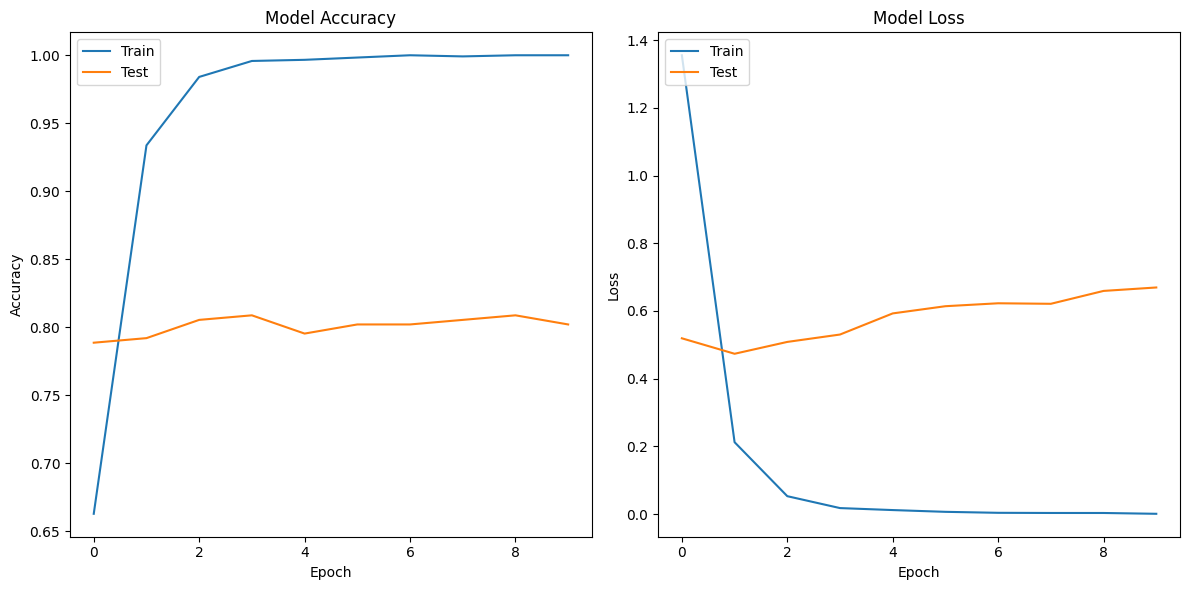

In [228]:
# plot figure
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot loss
plt.subplot(1,2,2)
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Adjust the layout and display the plots
plt.tight_layout()

In [229]:
final_loss, final_accuracy = final_model.evaluate(X_test, y_test)
print(f'Final Model Loss: {final_loss}')
print(f'Final Model Accuracy: {final_accuracy}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8228 - loss: 0.5899
Final Model Loss: 0.669325053691864
Final Model Accuracy: 0.8020133972167969
